In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from src.dataset import *
from src.model import *

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
config = {
    'local_depth': 16,
    'local_convdepth': 32,
    'global_depth': 5,
    'global_convdepth': 64,
    'global_imagesize': 128,
    'scale': 0.25}

model = CIEXYZNet(**config)

2022-05-31 12:06:37.148410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-31 12:06:37.175945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-31 12:06:37.176274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-31 12:06:37.176632: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with t

In [3]:
EPOCHS = 50
loss_fn = CompiledMAELoss()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metric_fn = tf.keras.metrics.Mean()

train_dataset = DataLoader("training")
test_dataset = DataLoader("validation")
val_dataset = DataLoader("testing")

train_steps = len(train_dataset)

history = []
for epoch in range(1, EPOCHS+1):
    print(f"Epoch {epoch}/{EPOCHS}")
    progbar = tf.keras.utils.Progbar(
        train_steps, interval=0.05,
        stateful_metrics=['loss', 'val_loss'])
    for step, train_batch in enumerate(train_dataset.data):
        sRGB_image = train_batch['sRGB_image']
        XYZ_image = train_batch['XYZ_image']
        with tf.GradientTape() as tape:
            train_logits = model(sRGB_image, training=True)
            train_loss = loss_fn((XYZ_image, sRGB_image), train_logits) 

        grads = tape.gradient(train_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        metric_fn.update_state(train_loss)
        train_mae = metric_fn.result()
        progbar.update(step, values=[('loss', train_mae)], finalize=False)
    
    metric_fn.reset_state()
    
    for val_batch in val_dataset.data:
        sRGB_image = val_batch['sRGB_image']
        XYZ_image = val_batch['XYZ_image']
        val_logits = model(sRGB_image)
        val_loss = loss_fn((XYZ_image, sRGB_image), val_logits) 
        metric_fn.update_state(val_loss)

    val_mae = metric_fn.result()
    values = {
        'loss': train_mae.numpy(),
        'val_loss': val_mae.numpy(),
    }
    progbar.update(
        train_steps, 
        values=values.items(),
        finalize=True)
    metric_fn.reset_state()

    history.append(values)

Epoch 1/50


2022-05-31 12:06:39.525378: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400
2022-05-31 12:06:40.552151: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


121/121 [==============================] - 21s 147ms/step - loss: 2.0946 - val_loss: 0.3856
Epoch 2/50
121/121 [==============================] - 17s 141ms/step - loss: 0.4449 - val_loss: 0.2937
Epoch 3/50
121/121 [==============================] - 17s 141ms/step - loss: 0.3490 - val_loss: 0.2464
Epoch 4/50
121/121 [==============================] - 17s 141ms/step - loss: 0.3048 - val_loss: 0.2070
Epoch 5/50
121/121 [==============================] - 17s 141ms/step - loss: 0.2699 - val_loss: 0.1836
Epoch 6/50
121/121 [==============================] - 17s 142ms/step - loss: 0.2332 - val_loss: 0.1782
Epoch 7/50
121/121 [==============================] - 17s 142ms/step - loss: 0.2055 - val_loss: 0.1498
Epoch 8/50
121/121 [==============================] - 17s 142ms/step - loss: 0.1903 - val_loss: 0.1340
Epoch 9/50
121/121 [==============================] - 18s 144ms/step - loss: 0.1774 - val_loss: 0.1379
Epoch 10/50
121/121 [==============================] - 18s 145ms/step - loss: 0.1665

Text(0, 0.5, 'MAE')

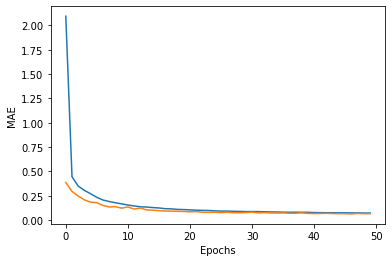

In [7]:
history = pd.DataFrame.from_records(history)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MAE')